In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
from BZI.pseudopots import find_intvecs
from BZI.pseudopots import AlPP
# from BZI.pseudopots import SiPP
from BZI.symmetry import sym_path
import matplotlib.pyplot as plt
from BZI.symmetry import make_ptvecs,make_rptvecs
from BZI.plots import PlotMesh
from numpy.linalg import norm
import itertools
import time

### Plot the band structure of Si

In [ ]:
def sphere_pts(A,r,offset):
    """ Calculate all the points within a sphere that are 
    given by an integer linear combination of the columns of 
    A.
    
    Args:
        A (numpy.ndarray): the grid basis with the columns 
            representing grid vectors.
        r (float): the squared radius of the sphere.
        offset(list or numpy.ndarray): a vector that points to the center
            of the sphere.
        
    Returns:
        grid (list): an array of grid coordinates in cartesian
            coordinates.
    """
    
    offset = np.asarray(offset)
    oi= np.dot(np.linalg.inv(A),offset)
    oi = oi.astype(int)
    imax = int(np.ceil(r/np.dot(A[:,0],A[:,0]))) + 2
    jmax = int(np.ceil(r/np.dot(A[:,1],A[:,1]))) + 2
    kmax = int(np.ceil(r/np.dot(A[:,2],A[:,2]))) + 2
    grid = []
    for i,j,k in itertools.product(range(-imax + oi[0],imax + oi[0]),
                                   range(-jmax + oi[1],jmax + oi[1]),
                                   range(-kmax + oi[2],kmax + oi[2])):
        pt = np.dot(A,[i,j,k])
        if np.dot(pt-offset,pt-offset) <= r:
            grid.append(pt)
        else:
            continue                
    return grid

In [13]:
def sphere_pts(A,r,offset):
    """ Calculate all the points within a sphere that are 
    given by an integer linear combination of the columns of 
    A.
    
    Args:
        A (numpy.ndarray): the grid basis with the columns 
            representing grid vectors.
        r (float): the squared radius of the sphere.
        offset(list or numpy.ndarray): a vector that points to the center
            of the sphere.
        
    Returns:
        grid (list): an array of grid coordinates in cartesian
            coordinates.
    """
    
    offset = np.asarray(offset)
    oi= np.dot(np.linalg.inv(A),offset)
    oi = oi.astype(int)
    imax = int(np.ceil(r/np.dot(A[:,0],A[:,0]))) + 2
    jmax = int(np.ceil(r/np.dot(A[:,1],A[:,1]))) + 2
    kmax = int(np.ceil(r/np.dot(A[:,2],A[:,2]))) + 2
    grid = []
    for i,j,k in itertools.product(range(-imax + oi[0],imax + oi[0]),
                                   range(-jmax + oi[1],jmax + oi[1]),
                                   range(-kmax + oi[2],kmax + oi[2])):
        pt = np.dot(A,[i,j,k])
        if np.dot(pt-offset,pt-offset) <= r:
            grid.append(pt)
        else:
            continue                
    return grid

In [25]:
def SiPP(kpoint, nbands, matrix=False):
    """Evaluate an Si pseudopotential at a given k-point. The pseudopotential
    form factors were taken from 
    `Harrison <https://journals.aps.org/pr/abstract/10.1103/PhysRev.141.789`_.

    Args:
        kpoint (numpy.array): a sampling point in k-space in cartesian coordinates.
        nbands (int): the number of eigenvalues to return
        matrix (Boolean): if True, the Hamiltoniam matrix is returned.

    Return:
        (numpy.array): the sorted eigenvalues of the Hamiltonian at the provided
        k-point.
    """
    
    Si_pff =   [-0.21, 0.04, 0.08, 0.00, 0.00, 0.00]
    lat_type = "fcc"
    a = 10.261212118
    rlat_vecs = make_rptvecs(lat_type, a)
    kpoint = np.asarray(kpoint)
    # This is the lattice constant in Bohr, the atomic SI unit
    lat_type = "fcc"
    tau = a/8*np.array([1,1,1])
    atomic_basis = [tau, -tau]

    # These reciprocal lattice points are in Cartesian coordinates but have had
    # 2*np.pi/a factored out so that they are integers.
#     Si_rlat_pts = (find_intvecs(0) + find_intvecs(3) +
#                   find_intvecs(4) + find_intvecs(8) +
#                   find_intvecs(11)  + find_intvecs(12) + 
#                   find_intvecs(16) + find_intvecs(19))
    
    # The cutoff in the Fourier transform comes from the paper by Cohen and Bergstresser
    r = 21*(2*np.pi/a)**2
    # rlat_pts = sphere_pts(rlat_vecs,r,kpoint)
    rlat_pts = [[i,j,k] for i,j,k in itertools.product(range(-5,5),repeat=3)]

    # Initialize the Si pseudopotential Hamiltonian.
    Si_H = np.zeros([len(rlat_pts), len(rlat_pts)], dtype=complex)
    # Construct the Al Hamiltonian.
    for d_nu in atomic_basis:
        for (i, h1) in enumerate(rlat_pts):
            h1 = np.asarray(h1)
            for (j, h2) in enumerate(rlat_pts):
                h2 = np.asarray(h2)
                q = h1 - h2
                n2 = norm(q)**2
                if np.isclose(n2, 3):
                    Si_H[i,j] += Si_pff[0]*np.exp(-1j*2*np.pi/a*np.dot(q, d_nu))
                elif np.isclose(n2, 8):
                    Si_H[i,j] += Si_pff[1]*np.exp(-1j*2*np.pi/a*np.dot(q, d_nu))
                elif np.isclose(n2, 11):
                    Si_H[i,j] += Si_pff[2]*np.exp(-1j*2*np.pi/a*np.dot(q, d_nu))
                elif i == j:
                    Si_H[i,i] += norm(kpoint + 2*np.pi/a*h1)**2/len(atomic_basis)
                else:
                    pass
    if matrix == True:
        return Si_H
    else:
        return np.linalg.eigvalsh(Si_H)[:nbands]

In [26]:
sympt_pairs = [("L","G"),("G","X"),("X","K"),("K","G")]
lat_type = "fcc"
# Si_lat_const = 2*np.pi
Si_lat_const = 10.26
npts = 5
# The k-points between symmetry points in reciprocal lattice coordinates.
lat_kpoints = sym_path(lat_type,npts,sympt_pairs)
rlat_vecs = make_rptvecs(lat_type, Si_lat_const)
# The k-points between symmetry points in cartesian coordinates.
car_kpoints = [np.dot(rlat_vecs,k) for k in lat_kpoints]

energies = []
nbands = 20
Ry_to_eV = 13.606
t = time.time()
for pkpt in car_kpoints:
    energies.append(SiPP(pkpt, nbands)*Ry_to_eV)
print(time.time() - t)

KeyboardInterrupt: 

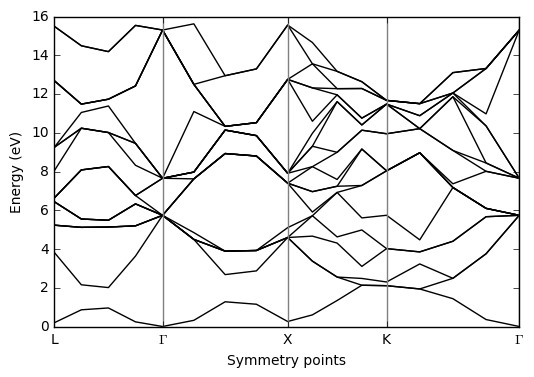

In [22]:
L = np.array(car_kpoints[0])
G = np.array(car_kpoints[npts-1])
X = np.array(car_kpoints[2*(npts-1)])
K = np.array(car_kpoints[3*(npts-1)])
G2 = np.array(car_kpoints[4*(npts-1)])

l1 = np.linalg.norm(G - L)
l2 = np.linalg.norm(X - G)
l3 = np.linalg.norm(K - X)
l4 = np.linalg.norm(G2 - K)
ltot = l1 + l2 + l3 + l4

line1 = list(np.delete(np.linspace(0,l1,npts),-1))
line2 = list(np.delete(np.linspace(l1,l1+l2,npts),-1))
line3 = list(np.delete(np.linspace(l1+l2,l1+l2+l3,npts),-1))
line4 = list(np.linspace(l1+l2+l3,l1+l2+l3+l4,npts))
lines = line1 + line2 + line3 + line4

for nb in range(nbands):
    ienergy = []
    for nk in range(len(lat_kpoints)):
        ienergy.append(energies[nk][nb])
    if nb == 0:
        plt.plot(lines, ienergy, color="black")# label="Band structure",color="black")
    else:
        plt.plot(lines, ienergy, color="black")
        
plt.axvline(x = l1, c="gray")
plt.axvline(x = l1 + l2, c="gray")
plt.axvline(x = l1 + l2 + l3, c="gray")
plt.axvline(x = l1 + l2 + l3 + l4, c="gray")

tick_labels = ["L", "$\Gamma$", "X", "K", "$\Gamma$"]
tick_locs = [0, l1, l1 + l2, l1 + l2 + l3, l1 + l2 + l3 + l4]

plt.xticks(tick_locs,tick_labels)
# plt.yticks(range(-5,8,1),range(-5,8,1))
# plt.ylim([-5, 7])
plt.xlim([0,ltot])
plt.xlabel("Symmetry points")
plt.ylabel("Energy (eV)")
# lgd = plt.legend(loc='center left', bbox_to_anchor=(.115, .09),fancybox=True)
# lgd.get_frame().set_alpha(0.2)
# plt.savefig("Al_band_struct.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=1000,transparent=True)
plt.show()
plt.close()

In [ ]:
ns = [norm(k) for k in car_kpoints]
max(ns)*10.26/(2*np.pi)

In [ ]:
rlat_pts = (find_intvecs(0) + find_intvecs(3) +
            find_intvecs(4) + find_intvecs(8) +
            find_intvecs(11)  + find_intvecs(12) + 
            find_intvecs(16) + find_intvecs(19) +
            find_intvecs(56))
rlat_pts = [2*np.pi/10.26*np.array(rl) for rl in rlat_pts]

In [ ]:
rns = [norm(k) for k in rlat_pts]
max(rns)**2

In [20]:
t = time.time()
SiPP([5,0,0],10)
print(time.time() - t)

2.622684955596924
